In [68]:
## ============================== || BEGIN : DIR || ============================== ## 
Delphes_DIR = "/home/franky8939/PROGRAMAS/MG5_aMC_v2_6_7/Delphes/"
ROOT_DIR = "/home/franky8939/PROGRAMAS/root-6.18.02/"
inputFileROOT = "darkphoton_5GeV_ctau0" # + .root
## ============================== || END   : DIR || ============================== ## 
import sys
## ======================== || BEGIN : PATH IN PROYECT || ======================== ## 
""" 
This is necesary for import path for the bash because in the Jupyter of Pycharm 
not charge this bash include in the environment and is necessary por import the 
module of the program ROOT CERN 
"""
# not necesary for the moment
sys.path.extend([ Delphes_DIR ])  
sys.path.extend([ Delphes_DIR + "classes" ])
sys.path.extend([ Delphes_DIR + "external" ])
sys.path.extend([ Delphes_DIR + "external/ExRootAnalysis" ])
# necesary in the different configuration of installation of ROOT
sys.path.extend([ ROOT_DIR    + "lib" ])
sys.path.extend([ ROOT_DIR    + "root/lib" ])
sys.path.extend([ ROOT_DIR    + "build/lib" ])
## ======================== || END   : PATH IN PROYECT || ======================== ## 
import ROOT 
## ===================== || BEGIN : PYTHONPATH IN PROYECT || ===================== ## 
"""
This is necesary for import the path for the library of ROOT CERN and Delphes  
"""
ROOT.gInterpreter.AddIncludePath( Delphes_DIR )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "classes" )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "external/" )
ROOT.gInterpreter.AddIncludePath( Delphes_DIR + "external/ExRootAnalysis/" )
ROOT.gSystem.Load( Delphes_DIR + "libDelphes")

ROOT.gInterpreter.Declare('#include "DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "SortableObject.h"')
ROOT.gInterpreter.Declare('#include "ExRootTask.h"')
## ===================== || END   : PYTHONPATH IN PROYECT || ===================== ## 
## ============================ || BEGIN : MODULES || ============================ ## 
''' Modules using '''
import os
#import plotly.graph_objects as go 
import matplotlib.pyplot as plt
import numpy as np
#import statistics as stats # usar media o desviacion estandar
## ============================ || END   : MODULES || ============================ ## 

In [91]:
## ========================== || BEGIN : DEFINITION || =========================== ## 
class darkSUSY:
    def __init__(self):
        #self.config = None                             # type: object
        #self.registro = None                           # type: object
        self.registroName = "DarkSUSY Event Log"        # type: str
        self.registroDir  = "Log/"                      # type: str 
        self.File = None
        self.Entries = None
        self.Nmuon = None
        self.MaxMuon = 4
        self.DiMuon2 = None
        self.MinDiMuon2 = None
        self.ArchivoMuon = "LOG OF SELECCION OF TWO MUONS.txt"
        self.ArchivoMuonLOG = 1
        """ """
        self.Hgrid = True 
        self.Hbins = 50 
        self.Hpercentil = 5
        self.Hylabel = " Frecuencia "
        self.Hstart = True
        
    def AddFile(self, 
                name           # type: str
                ):
        # type : (str, bool) -> bool
        """ ========================================================================
            || Charge the file type XXX.root output of caracterization of Delphes ||
            ========================================================================  """
        output = 1
        self.File = ROOT.TChain("Delphes;1")
        
        if isinstance(name,str) or isinstance(name + ".root",str): # existence of .root file
            if os.path.isfile(name) or os.path.isfile(name + ".root"):
                if  name[-5:]=='.root' :
                    self.File.Add(name)
                    print("The file " + name + ".root has been successfully loaded.")
                else:
                    self.File.Add(name + ".root")
                    print("The file " + name + " has been successfully loaded.")
            else:
                print("Error: The file " + name + " has not been successfully loaded, input dir is not exist.")
                output = 0
        else:
            print("Error: The file " + name + " has not been successfully loaded, input is not string.")
            output = 0
        
        # Variables necesarias para trabajar
        self.Entries = self.File.GetEntries() # Number of entrance
        self.Nmuon = np.array([])
        
        for entry in range(self.Entries):
            Event = self.File.GetEntry(entry)
            self.Nmuon = np.append(self.Nmuon, self.File.Muon.GetEntries())

        return output
    
    def Select_two_di_muon(self
                           ):
        
        f = open ("LOG OF SELECCION OF TWO MUONS.txt",'w') # CREATE TXT FILE TO SAVE THE CHARACTERIZATION PROCESS INFO
        output = []
        
        for entry in range(self.Entries):
            Event = self.File.GetEntry(entry)
            if  self.File.Muon.GetEntries() > self.MaxMuon - 1:
                Nmuon = self.File.Muon.GetEntries()
                Chargemuon = []
                f.write( "\n" + "||===========================================================================================================||")
                f.write( "\n" + "||                                 || SUMMARY OF EVENT CHARACTERIZATION ||                                   ||")
                f.write( "\n" + "||===========================================================================================================||")
                f.write( "\n" + "||                                   EVENT : "  + str(entry)  + " :: NUMBER OF MUONS : " + str(Nmuon) )
                
                for imuon in range(Nmuon):
                    Chargemuon.append(self.File.GetLeaf("Muon.Charge").GetValue( imuon ) )
                
                """ ===========================================================
                    || SELECT THE POSSIBLE DI-MUONES IN DEPENDENCE OF CHARGE ||
                    ===========================================================  """
                di_muon = []
                for one in range(len(Chargemuon)) :
                    for  two in range( one , len(Chargemuon) ) :
                        if  Chargemuon[one] + Chargemuon[two] == 0:
                            di_muon.append( [ one , two ] )

                """ ===========================================================
                             || ** SELECT THE PAIR WITH LOWER MASS ** ||
                    ===========================================================  """
                AllDiffInvMass = np.array([])        # type: float # 1D # Diff of Inv Mass
                AllInvMass     = np.array([])        # type: float # 2D # Values od Inv Mass
                Alltwo_di_muon = np.array([])        # type: float # 1D # All combination of Di-muon
                
                """" =================================
                     || COMBINATION OF TWO DI-MUONS ||
                     =================================  """
                for one in range( len(di_muon) ):
                    for two in range(one + 1, len(di_muon) ):
                        """" ============================
                             || Do not share particles ||
                             ============================  """
                        if di_muon[one][0] != di_muon[two][0] and di_muon[one][0] != di_muon[two][1]  and \
                                di_muon[one][1] != di_muon[two][0] and di_muon[one][1] != di_muon[two][1] :
                           
                            mass1 = ( self.File.Muon.At(di_muon[one][0]).P4() +
                                      self.File.Muon.At(di_muon[one][1]).P4() ).M() # First  Mass
                            mass2 = ( self.File.Muon.At(di_muon[two][0]).P4() +
                                      self.File.Muon.At(di_muon[two][1]).P4() ).M() # Second Mass
                            AllDiffInvMass = np.append( AllDiffInvMass , 
                                                        np.abs( mass1 - mass2 ) )  # [ (...) , |M1 - M2|]
                            # Indices di-muon1 (i,j) ; di-muon2 (n,m) -> [ i, j, n, m ]
                            two_di_muon = np.array([ di_muon[one][0] , di_muon[one][1] , 
                                                     di_muon[two][0] , di_muon[two][1] ])
                            if len(Alltwo_di_muon) == 0 :
                                Alltwo_di_muon = two_di_muon
                                AllInvMass     = [mass1 , mass2 ]
                            else:
                                Alltwo_di_muon = np.vstack( [ Alltwo_di_muon , two_di_muon      ] )
                                AllInvMass     = np.vstack( [ AllInvMass     , [mass1 , mass2 ] ] )
                
                f.write( "\n" + "||                                 =======================================                                   ||")  
                f.write( "\n" + "||                                 | All Couple of di-muones for select: |                                   ||")    
                f.write( "\n" + "||                                 =======================================                                   || ")  
                
                for count in range( len( AllInvMass ) ):
                    f.write("\n" + "||"+ " :: First di-muon: ["  + str(Alltwo_di_muon[count][0]) + " , " + str(Alltwo_di_muon[count][1]) + "] " + 
                          " with M1 : " + '%.2f' %AllInvMass[count][0] +
                          " :: Second di-muon: [" + str(Alltwo_di_muon[count][2]) + " , " + str(Alltwo_di_muon[count][3]) + "] " + 
                          " with M2 : " + '%.2f' %AllInvMass[count][1] + 
                          " :: \u0394 Minv : "  + '%.3f' %AllDiffInvMass[count])
                    
                f.write("\n" + "||                                 =======================================                                   ||")  
                f.write("\n" + "||                                 | The Couple of di-muones select is : |                                   ||")    
                f.write("\n" + "||                                 =======================================                                   ||")  
                
                # MIN OF MASS DIF IN THE VECTOR AllInvMAss
                logic = np.where(np.min( AllDiffInvMass ) == AllDiffInvMass)[0][0] # MATRIX LOGIC
                #print(logic)
                DiMuon2 = (Alltwo_di_muon[logic]) # TWO DI-MUON WITH > (MASS1-MASS2)

                f.write("\n" + "||"+ " :: First di-muon: [" + str(DiMuon2[0]) + " , " + str(DiMuon2[1]) + "] " + 
                          " with M1 : " + '%.2f' %AllInvMass[logic][0] +
                          " :: Second di-muon: [" + str(DiMuon2[2]) + " , " + str(DiMuon2[3]) + "] " + 
                          " with M2 : " + '%.2f' %AllInvMass[logic][1])  #'''
                f.write( "\n" + "||===========================================================================================================||")
                
                ## ALL DI-MUON FOR EVENT
                if  len(output)==0:
                    output =np.hstack([entry,DiMuon2])
                else:
                    intg=np.hstack([ entry , DiMuon2])
                    output = np.vstack( [ output , intg] )
        f.close()
        ## RESUMEN FINAL
        '''print("De los ", self.Entries , " eventos procesados, ", sum(self.Nmuon>3) , " poseen mas de 3 muones y ",
              output.shape[0] , " fueron seleccionados bajo el criterio de minima masa invariante.")'''
        return output
    
    def fhist(self, entrada):
    
        if self.Hpercentil>0 and self.Hpercentil<100 :
            log1 = np.percentile(entrada, self.Hpercentil)  < entrada 
            log2 = np.percentile(entrada, 100 - self.Hpercentil) > entrada
            log =log1*log2
            hist = []
            for i in range(len(entrada)):
                if log[i]:
                    hist.append(entrada[i])
        else:
            hist = entrada
            log = True
        ## GRAF
        
        if  hasattr(self, "Hbins") : 
            if hasattr(self, "Hxlim") :
                binss=int(round(self.Hbins*(max(hist)- min(hist))/(self.Hxlim[1]- self.Hxlim[0])))
                #print(binss)
                plt.hist(np.delete(hist, log), bins= binss)
            else:
                plt.hist(np.delete(hist, log), bins= self.Hbins)
        else:
            plt.hist(np.delete(hist, log), bins= 10)                 
                
        ## PROP
        if    hasattr(self, "Hxlim"): plt.xlim(self.Hxlim[0],self.Hxlim[1] )
        else: plt.xlim( min(hist), max(hist) )
        if    hasattr(self, "Hylim"): plt.ylim(self.Hylim[0],self.Hylim[1] )
        
        if    hasattr(self, "Htitle") and len(self.Htitle)>0: plt.title(self.Htitle)
        
        if    hasattr(self, "Hgrid"): plt.grid(self.Hgrid)
        else: plt.grid(True)
        
        if    hasattr(self, "Hylabel") and len(self.Hylabel)>0 : plt.ylabel(self.Hylabel)
        if    hasattr(self, "Hxlabel") and len(self.Hxlabel)>0 : plt.xlabel(self.Hxlabel)
       
        if    self.Hstart : plt.show()
        else: print(" Auto plot is deactivate, change the bool .\"start\" ")
        plt.clf() # closed
        return 0
    
    def HistM(self):
        # MASA DE LOS DI-MUONES
        AllMass_of_photon = []
        AllminMass_of_photon = []
        AllmaxMass_of_photon = []
        ALL_DMuon_ForEvent = np.array(self.MinDiMuon2)
        for event_2dark in range( self.MinDiMuon2.shape[0] ) :#range( entries  ):
            Event = self.File.GetEntry(ALL_DMuon_ForEvent[ event_2dark,0 ])
            muones = self.File.Muon
            mass1 = ( muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 1] ) ).P4() + 
                      muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 2] ) ).P4() ).M()
            mass2 = ( muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 3] ) ).P4() + 
                      muones.At( int( ALL_DMuon_ForEvent[ event_2dark , 4] ) ).P4() ).M()
            AllMass_of_photon.append(mass1)
            AllMass_of_photon.append(mass2)
            if mass1 > mass2:
                AllminMass_of_photon.append(mass2)
                AllmaxMass_of_photon.append(mass1)
            else:
                AllminMass_of_photon.append(mass1)
                AllmaxMass_of_photon.append(mass2)
                
        # Histogram of all mass
        self.Hxlim = [np.percentile(AllMass_of_photon, 1), np.percentile(AllMass_of_photon, 99)]
        #plt.figure(1)
        plt.rcParams['figure.figsize'] = [10, 20]
        plt.subplot(311); 
        self.Htitle  = 'Masas de todos los DarkPhoton'
        self.Hpercentil = 2
        self.fhist(AllMass_of_photon)
        
        plt.subplot(312); 
        self.Htitle  = 'Masas mayores de todos los DarkPhoton'
        self.Hpercentil = 0
        self.fhist(AllmaxMass_of_photon)
        
        plt.subplot(313); 
        self.Htitle  = 'Masas menores de todos los DarkPhoton'
        self.Hpercentil = 0
        self.fhist(AllminMass_of_photon)
        
    def HistPt(self):
        AllPt_of_photon = []
        All1Pt_of_photon = []
        All2Pt_of_photon = []
        All3Pt_of_photon = []
        All4Pt_of_photon = []
        ALL_DMuon_ForEvent = np.array(self.MinDiMuon2)
        for event_2dark in range( self.MinDiMuon2.shape[0] ) :#range( entries  ):
            #print(event_2dark)
            Event = self.File.GetEntry(ALL_DMuon_ForEvent[ event_2dark,0 ])
            
            for imuon in range(4):
                AllPt_of_photon.append(self.File.GetLeaf("Muon.PT").GetValue( imuon ))
            AllPt_of_photon_event = np.hstack( [ AllPt_of_photon[-4:-1] , AllPt_of_photon[-1] ] )  
            AllPt_of_photon_event = np.sort(AllPt_of_photon_event)
            All1Pt_of_photon.append(AllPt_of_photon_event[0])
            All2Pt_of_photon.append(AllPt_of_photon_event[1])
            All3Pt_of_photon.append(AllPt_of_photon_event[2])
            All4Pt_of_photon.append(AllPt_of_photon_event[3])
            
        ## HISTOGRAMAS DE TODOS LOS MOMENTOS ANGULARES
        self.Hxlim = [ min(AllPt_of_photon_event), max(AllPt_of_photon_event)]
        #plt.figure(1)
        plt.rcParams['figure.figsize'] = [10, 20]
        plt.subplot(511); 
        self.Htitle  = 'Momento Transversal de todos los Muones'
        self.fhist(AllPt_of_photon)
        self.Hxlabel = " Momento Transversal"
        self.Hpercentil = 0
        plt.subplot(512);
        self.Htitle = "Momento Transversal de los Muones en la posicion 1"#'''
        self.fhist(All1Pt_of_photon)
        plt.subplot(513);
        self.Htitle = "Momento Transversal de los Muones en la posicion 2"#'''
        self.fhist(All2Pt_of_photon)
        plt.subplot(514);
        self.Htitle = "Momento Transversal de los Muones en la posicion 3"#'''
        self.fhist(All3Pt_of_photon)
        plt.subplot(515);
        self.Htitle = "Momento Transversal de los Muones en la posicion 4"#'''
        self.fhist(All4Pt_of_photon)

The file darkphoton_5GeV_ctau0 has been successfully loaded.
1
[[  29    0    3    1    2]
 [  57    0    3    1    2]
 [  65    0    2    1    3]
 ...
 [9973    0    2    1    3]
 [9986    0    1    2    3]
 [9989    0    2    1    3]]


In [92]:
        
DarkFile = darkSUSY()
print(DarkFile.AddFile(inputFileROOT))
print(DarkFile.Select_two_di_muon())
#print(DarkFile.Nmuon)

The file darkphoton_5GeV_ctau0 has been successfully loaded.
1
('De los ', 10000L, ' eventos procesados, ', 508, ' poseen mas de 3 muones y ', 508, ' fueron seleccionados bajo el criterio de minima masa invariante.')
[[  29    0    3    1    2]
 [  57    0    3    1    2]
 [  65    0    2    1    3]
 ...
 [9973    0    2    1    3]
 [9986    0    1    2    3]
 [9989    0    2    1    3]]


/home/franky8939/PROGRAMAS/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:174: FutureWarning:

in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer



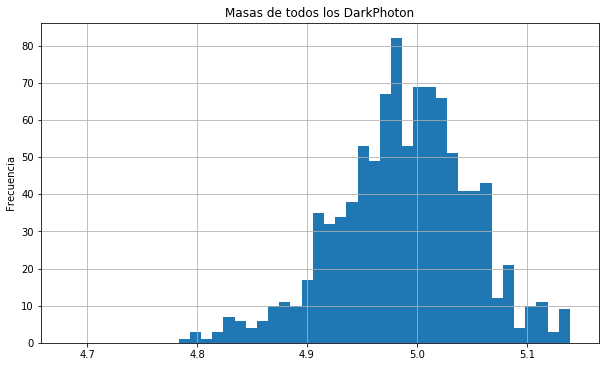

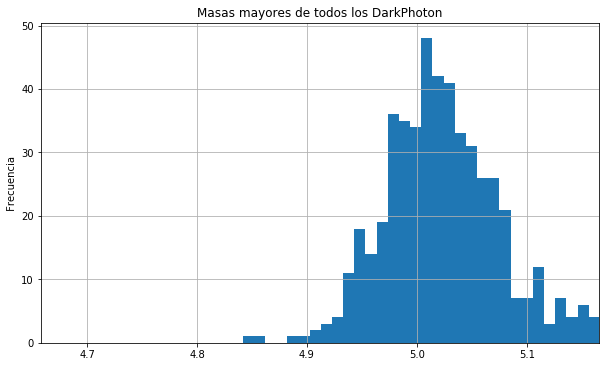

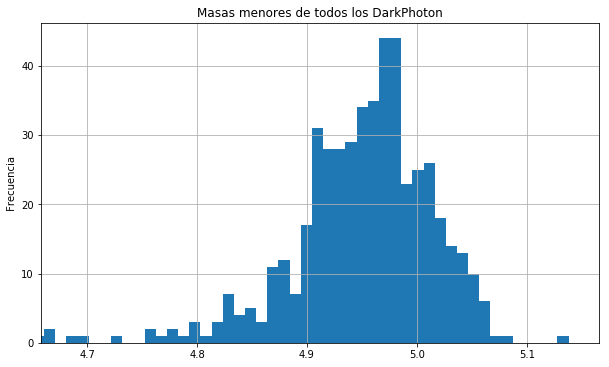

None


<Figure size 720x1440 with 0 Axes>

In [83]:
print(DarkFile.HistM())

/home/franky8939/PROGRAMAS/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:174: FutureWarning:

in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer



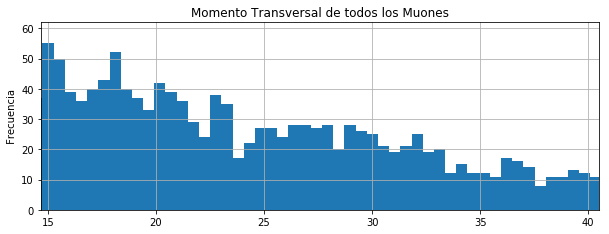

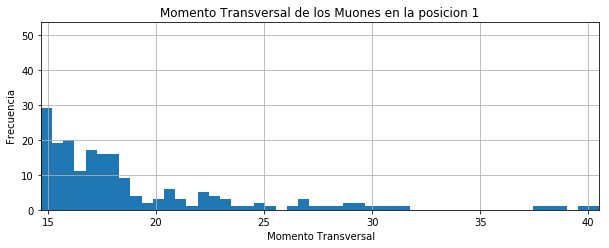

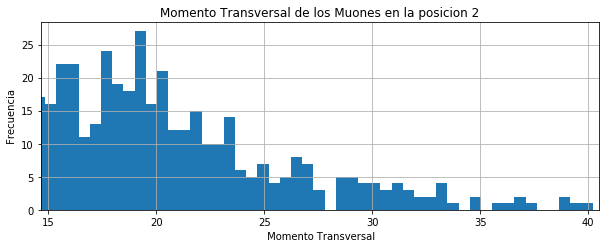

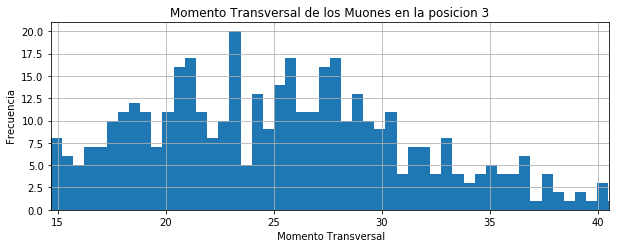

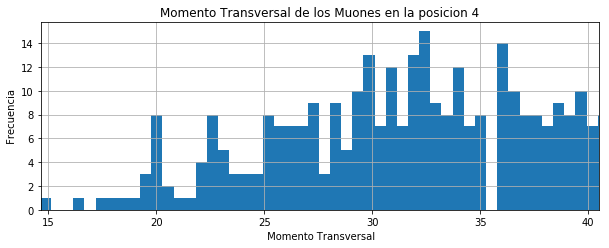

None


<Figure size 720x1440 with 0 Axes>

In [90]:
print(DarkFile.HistPt())